In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import os

BASE_DIR = r"C:\claude-code\PCD_Final_Project\TB_Chest_Radiography_Database"
normal_dir = os.path.join(BASE_DIR, "Normal")
tb_dir = os.path.join(BASE_DIR, "Tuberculosis")

print("Normal images:", len(os.listdir(normal_dir)))
print("TB images:", len(os.listdir(tb_dir)))


Normal images: 3500
TB images: 700


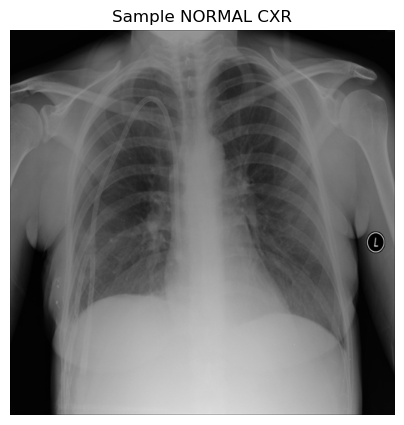

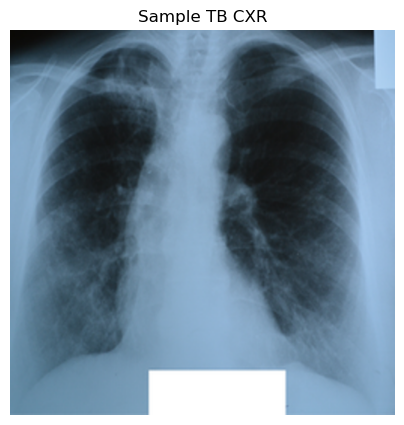

In [2]:
# Show 1 example Normal image
sample_normal = os.listdir(normal_dir)[0]
img_normal = cv2.imread(os.path.join(normal_dir, sample_normal))
img_normal = cv2.cvtColor(img_normal, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.imshow(img_normal)
plt.title("Sample NORMAL CXR")
plt.axis("off")
plt.show()

# Show 1 example Tuberculosis image
sample_tb = os.listdir(tb_dir)[0]
img_tb = cv2.imread(os.path.join(tb_dir, sample_tb))
img_tb = cv2.cvtColor(img_tb, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.imshow(img_tb)
plt.title("Sample TB CXR")
plt.axis("off")
plt.show()


In [3]:
IMG_SIZE = 512  # target size

def preprocess_image(img_bgr):
    """
    Input  : img_bgr (OpenCV image in BGR)
    Output : preprocessed grayscale image (float32, 0–1, size 512x512)
    """
    # 1. Resize ke 512x512 supaya semua seragam
    img_resized = cv2.resize(img_bgr, (IMG_SIZE, IMG_SIZE))
    
    # 2. Convert BGR -> Grayscale
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    
    # 3. CLAHE (Contrast Limited Adaptive Histogram Equalization)
    #    ini yang dipakai juga di paper sebagai peningkatan kualitas kontras
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    # 4. Noise reduction (median blur) untuk buang noise kecil tapi tetap jaga edge
    denoised = cv2.medianBlur(enhanced, 3)
    
    # 5. Normalisasi ke 0–1 (float32)
    norm = denoised.astype(np.float32) / 255.0
    
    return norm


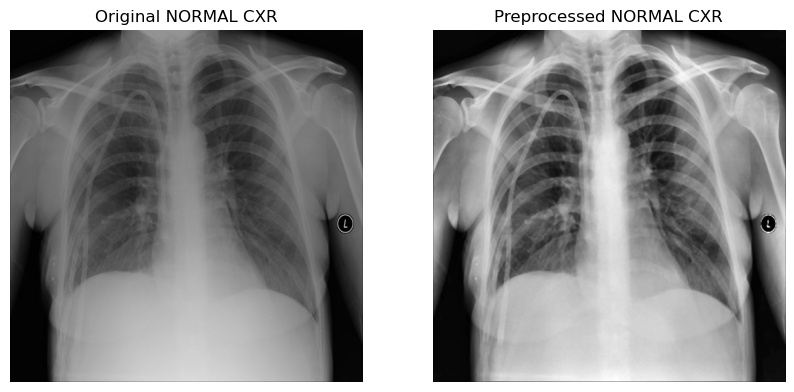

In [4]:
# Ambil 1 contoh gambar Normal lagi
sample_normal = os.listdir(normal_dir)[0]
img_normal_bgr = cv2.imread(os.path.join(normal_dir, sample_normal))

# Preprocess
img_normal_proc = preprocess_image(img_normal_bgr)

# Tampilkan sebelum & sesudah
plt.figure(figsize=(10,5))

# Sebelum (RGB)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_normal_bgr, cv2.COLOR_BGR2RGB))
plt.title("Original NORMAL CXR")
plt.axis("off")

# Sesudah (grayscale hasil preprocessing)
plt.subplot(1, 2, 2)
plt.imshow(img_normal_proc, cmap="gray")
plt.title("Preprocessed NORMAL CXR")
plt.axis("off")

plt.show()


In [5]:
from skimage.filters import threshold_otsu
from skimage.morphology import closing, opening, disk, remove_small_objects

def segment_lungs(img):
    """
    Input : img (grayscale preprocessed 512x512, 0-1 float)
    Output: lung_mask (boolean mask), and lung-only image
    """

    # Convert ke range 0–255 lagi untuk thresholding Otsu
    img_uint8 = (img * 255).astype(np.uint8)

    # 1. Otsu threshold
    thresh = threshold_otsu(img_uint8)
    mask = img_uint8 > thresh   # True/False mask

    # 2. Morphology cleaning
    mask = closing(mask, disk(5))   # tutup lubang kecil
    mask = opening(mask, disk(5))   # hapus noise kecil
    mask = remove_small_objects(mask, 300)  # buang objek kecil (<300 pixel)

    return mask


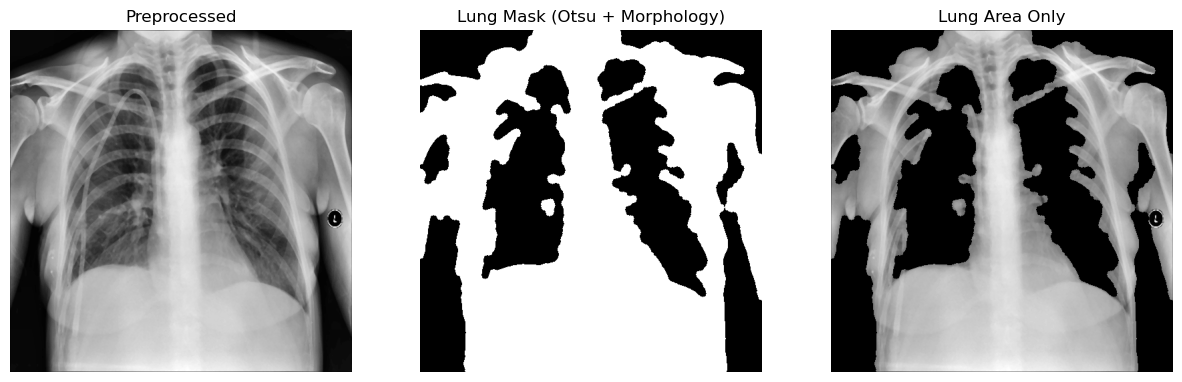

In [6]:
# Preprocess one image
sample_normal = os.listdir(normal_dir)[0]
img_normal_bgr = cv2.imread(os.path.join(normal_dir, sample_normal))
img_prep = preprocess_image(img_normal_bgr)

# Segmentation
lung_mask = segment_lungs(img_prep)

# Apply mask (ambil hanya area paru-paru)
lung_only = img_prep * lung_mask

# Plot hasilnya
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img_prep, cmap="gray")
plt.title("Preprocessed")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(lung_mask, cmap="gray")
plt.title("Lung Mask (Otsu + Morphology)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(lung_only, cmap="gray")
plt.title("Lung Area Only")
plt.axis("off")

plt.show()


In [7]:
from skimage.feature import graycomatrix, graycoprops

def extract_glcm_features(img):
    """
    Input : img (lung-only grayscale image, 0-1, 512x512)
    Output: 1D feature vector (numpy array) berisi fitur GLCM
    """
    # Konversi ke 0–255 (uint8), GLCM butuh nilai integer tingkat keabuan
    img_uint8 = (img * 255).astype(np.uint8)

    # Definisikan jarak dan sudut (sama ide dengan paper: beberapa jarak, 4 arah)
    distances = [1, 2, 4]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    # Hitung GLCM
    glcm = graycomatrix(
        img_uint8,
        distances=distances,
        angles=angles,
        levels=256,        # tingkat keabuan (0–255)
        symmetric=True,
        normed=True
    )

    # Ambil beberapa properti GLCM
    features = []

    for prop in ['contrast', 'correlation', 'energy', 'homogeneity']:
        vals = graycoprops(glcm, prop)  # shape: (len(distances), len(angles))
        features.extend(vals.ravel())   # flatten & tambahkan ke list

    # Jadikan numpy array
    return np.array(features, dtype=np.float32)


In [8]:
# 1. Ambil satu contoh gambar TB atau Normal
sample_tb_file = os.listdir(tb_dir)[0]
img_tb_bgr = cv2.imread(os.path.join(tb_dir, sample_tb_file))

# 2. Preprocess
img_tb_prep = preprocess_image(img_tb_bgr)

# 3. Segmentation (lung mask)
tb_mask = segment_lungs(img_tb_prep)
tb_lung_only = img_tb_prep * tb_mask

# 4. Extract GLCM features
glcm_feat = extract_glcm_features(tb_lung_only)

print("GLCM feature vector shape:", glcm_feat.shape)
print("First 10 features:", glcm_feat[:10])


GLCM feature vector shape: (48,)
First 10 features: [126.57791  172.7284   103.821976 168.52185  272.18658  172.7284
 221.08302  168.52185  600.86206  606.727   ]


In [9]:
from skimage.feature import local_binary_pattern

def extract_lbp_features(img, P=16, R=2):
    """
    Input: img (lung-only grayscale image, 0-1 float)
    Output: LBP histogram (59 bins for uniform pattern)
    """
    # LBP expects uint8 image
    img_uint8 = (img * 255).astype(np.uint8)

    # Uniform LBP
    lbp = local_binary_pattern(img_uint8, P=P, R=R, method='uniform')

    # Histogram with 59 bins (uniform)
    hist, _ = np.histogram(lbp.ravel(), bins=59, range=(0, 59), density=True)

    return hist.astype(np.float32)


In [10]:
lbp_feat = extract_lbp_features(tb_lung_only)

print("LBP feature shape:", lbp_feat.shape)
print("First 10 LBP features:", lbp_feat[:10])


LBP feature shape: (59,)
First 10 LBP features: [0.00834274 0.00442886 0.00908279 0.01169586 0.01260376 0.02095795
 0.03085709 0.06463623 0.08374786 0.08119583]


In [16]:
def process_single_image(img_path):
    """
    Returns: 1D feature vector for this image
    """
    img_bgr = cv2.imread(img_path)

    # Preprocess
    img_prep = preprocess_image(img_bgr)

    # Segmentation
    mask = segment_lungs(img_prep)
    lung_only = img_prep * mask

    # Feature extraction
    feats = extract_all_features_from_lung(lung_only)
    return feats


In [26]:
X_bal = []
y_bal = []

print("Processing BALANCED NORMAL images...")
for filename in tqdm(normal_files_balanced):
    img_path = os.path.join(normal_dir, filename)
    feats = process_single_image(img_path)
    X_bal.append(feats)
    y_bal.append(0)   # Normal = 0

print("Processing TB images...")
for filename in tqdm(tb_files):
    img_path = os.path.join(tb_dir, filename)
    feats = process_single_image(img_path)
    X_bal.append(feats)
    y_bal.append(1)   # TB = 1


Processing BALANCED NORMAL images...


100%|██████████| 700/700 [02:18<00:00,  5.06it/s]


Processing TB images...


100%|██████████| 700/700 [02:05<00:00,  5.59it/s]


In [27]:
X_bal = np.array(X_bal, dtype=np.float32)
y_bal = np.array(y_bal, dtype=np.int32)

print("X_bal shape:", X_bal.shape)
print("y_bal shape:", y_bal.shape)
print("Class 0 (Normal):", (y_bal==0).sum())
print("Class 1 (TB)    :", (y_bal==1).sum())


X_bal shape: (1400, 34703)
y_bal shape: (1400,)
Class 0 (Normal): 700
Class 1 (TB)    : 700


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal,
    test_size=0.3,
    stratify=y_bal,
    random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape :", y_test.shape)


X_train shape: (980, 34703)
X_test shape : (420, 34703)
y_train shape: (980,)
y_test shape : (420,)


In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("After PCA dim:", X_train_pca.shape[1])


After PCA dim: 800


In [31]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

svm = SVC(
    kernel='rbf',
    C=10,
    gamma=0.01,
    class_weight='balanced',
    random_state=42
)

svm.fit(X_train_pca, y_train)
y_pred = svm.predict(X_test_pca)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.5119047619047619

Classification Report:
               precision    recall  f1-score   support

           0       0.51      1.00      0.67       210
           1       1.00      0.02      0.05       210

    accuracy                           0.51       420
   macro avg       0.75      0.51      0.36       420
weighted avg       0.75      0.51      0.36       420


Confusion Matrix:
 [[210   0]
 [205   5]]


In [32]:
def extract_all_features_from_lung(lung_img):
    glcm_feat = extract_glcm_features(lung_img)
    lbp_feat  = extract_lbp_features(lung_img)

    all_feats = np.concatenate([glcm_feat, lbp_feat], axis=0)
    return all_feats


In [33]:
X_bal = []
y_bal = []

print("Processing BALANCED NORMAL images...")
for filename in tqdm(normal_files_balanced):
    img_path = os.path.join(normal_dir, filename)
    feats = process_single_image(img_path)
    X_bal.append(feats)
    y_bal.append(0)

print("Processing TB images...")
for filename in tqdm(tb_files):
    img_path = os.path.join(tb_dir, filename)
    feats = process_single_image(img_path)
    X_bal.append(feats)
    y_bal.append(1)

X_bal = np.array(X_bal, dtype=np.float32)
y_bal = np.array(y_bal, dtype=np.int32)

print("X_bal shape:", X_bal.shape)
print("y_bal shape:", y_bal.shape)


Processing BALANCED NORMAL images...


100%|██████████| 700/700 [02:04<00:00,  5.62it/s]


Processing TB images...


100%|██████████| 700/700 [01:49<00:00,  6.40it/s]

X_bal shape: (1400, 107)
y_bal shape: (1400,)


In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal,
    test_size=0.3,
    stratify=y_bal,
    random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape :", y_test.shape)


X_train shape: (980, 107)
X_test shape : (420, 107)
y_train shape: (980,)
y_test shape : (420,)


In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("After PCA dim:", X_train_pca.shape[1])


After PCA dim: 5


In [37]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

svm = SVC(
    kernel='rbf',
    C=10,
    gamma=0.01,
    class_weight='balanced',
    random_state=42
)

svm.fit(X_train_pca, y_train)
y_pred = svm.predict(X_test_pca)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9285714285714286

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93       210
           1       0.95      0.90      0.93       210

    accuracy                           0.93       420
   macro avg       0.93      0.93      0.93       420
weighted avg       0.93      0.93      0.93       420


Confusion Matrix:
 [[201   9]
 [ 21 189]]
